# Study (false) detections around bright stars
This notebook provides a plot that is very similar to that made in `BeyondRadius.ipynb`, but more "absolute": instead of looking at detection density in annulii of the same radius around each mask's edge, we compute them in annulii of the same radius _and distance_ around each bright star's center.

Andy Goulding's mask have radii chosen as a power law of the bright object's magnitude, so we will make this plot for per magnitude bin (see parameters in the second code cell below).

## Options
Similar to `BeyondRadius`, these are some options to select the detections and mask to load, as well as the annulii's parameters:

In [1]:
butlerPath = "/project/mschmitz/hscRerun/mynobg"

chosenFilter = "HSC-R" 
tractList = [9697] 
patchList = [["{},{}".format(i,j) for i in range(2,7) for j in range(2,7)]] * len(tractList)

# Annuli parameters
annSize = 2.5 # radius of each consecutive annulus, in arcsec
radMax = 150 # outer radius for the largest annulus

# which detections to keep
reselectBrightObjects = "boxAround" #False

# print a few checkpoints, validation plots, etc
verbose = True

# which mask to load - if False, loads Arcturus masks
gouldingMask = True

Change this cell for plot parameters: how to perform the magnitude binning (for bright objects), whether to have a common y-axis and whether plots should be saved or only displayed in the notebook. If `savePlots` here is set to True, and a folder with the name given in `outputDir` does not exist, it will be created.

In [2]:
# magnitude bins and corresponding labels
mag_bins = [0, 12, 14] + list(range(15,19))
mag_labs = ['mag < 12', '12 < mag < 14'] + [
            '{} < mag < {}'.format(mfrom,mto)
            for mfrom,mto in zip(mag_bins[2:],mag_bins[3:])]

# fix y-axis span to 0-to-2.5 times average detection density (as in Coupon et al., 2014, Fig. 8)
fixYAxis = True

# whether to save plots and what to call them
savePlots = True
outputDir = 'plots/'
plotStub = "2p5rad_upto150"
plotExt = ".png"

The rest of the notebook should not require any changes before being ran (though note the cell that actually computes the number counts can take up to a few minutes per tract, depending on annuli parameters).

## Set up
Usual imports:

In [3]:
%matplotlib inline
import numpy as np
from lsst.daf.persistence import Butler
from lsst import geom
import matplotlib.pyplot as plt
import os
import time

In [4]:
import helperFuncs

Token to avoid rereading the detections every time, eg if we want to play with annuli parameters

In [5]:
src_loaded = False 

Initialize Butler repo:

In [6]:
butler = Butler(butlerPath)

Define annuli borders and area:

In [7]:
annRadii = np.arange(0, radMax, annSize)
annAreas = np.array([np.pi *(radOut**2 - radIn**2) for
                     radIn,radOut in zip(annRadii,annRadii[1:])])

Path to masks:

In [8]:
if gouldingMask:
    # filenames have lower case filter in them:
    filterPrefix = "HSC-"
    if chosenFilter.startswith(filterPrefix) and len(chosenFilter[len(filterPrefix):]) == 1: 
        filter_lc = chosenFilter[len(filterPrefix):].lower() 
    else:
        raise RunTimeError(f"Filter name {chosenFilter} not recognized")
    print(filter_lc)
    mask_path = "/datasets/hsc/BrightObjectMasks/GouldingMasksS18A/new_S18Amask_{}.reg".format(
                                            filter_lc)
else:
    mask_path = "/datasets/hsc/BrightObjectMasks/ArcturusMasks/" 

r


If plots are to be saved, make sure the folder exists:

In [9]:
if savePlots:
    if not os.path.isdir(outputDir):
        os.makedirs(outputDir)

## Run
Warning: running cell below takes a while.

In [10]:
densities, brightMags, brightRads, brightCenters = [], [], [], []
for tract,patches in zip(tractList,patchList):
    # get sky map and WCS for this tract
    skymap = butler.get("deepCoadd_skyMap", tract=tract)
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    
    # convert annuli parameters to pixel
    pixScale = geom.radToArcsec(wcs.getPixelScale())
    radMaxPix = radMax / pixScale
    radiiPix = annRadii / pixScale
    
    # load detection catalog for each patch
    if verbose:
        print("Loading and appending all detections...")
    if not src_loaded:
        src = butler.get('deepCoadd_meas', tract=tract, patch=patches[0], 
                         filter=chosenFilter)
        src = src[src['detect_isPatchInner']]
        for patch in patches[1:]:
            patchSrc = butler.get('deepCoadd_meas', tract=tract, patch=patch, 
                                 filter=chosenFilter)
            patchSrc = patchSrc[patchSrc['detect_isPatchInner']]
            src.extend(patchSrc)
            src_loaded = True
    if verbose:
        print(" > Done.")
        
    # set up bright object selector if needed
    if reselectBrightObjects:
        if reselectBrightObjects == "boxAround":
            if verbose:
                print("Computing box boundaries...")
            # hacky box for a rectangular subset of patches within a tract:
            x0 = np.min(src["base_SdssCentroid_x"]) 
            xWidth = np.max(src["base_SdssCentroid_x"]) - x0
            y0 = np.min(src["base_SdssCentroid_y"]) 
            yWidth = np.max(src["base_SdssCentroid_y"]) - x0 
            selector = lambda brightCenters, brightMags, brightRadii : helperFuncs.boxSelector(
                                            brightCenters, brightRadii, x0, y0, xWidth, yWidth,
                                            extraBuffer=radMaxPix, from_center=True)
            if verbose:
                print(" > Done.")
    else:
        selector = None
        
    # load bright star masks
    if gouldingMask:
        # if we want to read from the files with all the masks;
        # mask_path should then be absolute path to there
        brightCenters, mags, rads = helperFuncs.extractBrightStarInfo( 
                                              tractInfo, mask_path, radInPix=False, verbose=verbose)
    else:
        # if we are reading Arcturus, we need to concatenate them for
        # all patches of interest first
        for j,patch in enumerate(patches):
            thismask = mask_path + '{}/BrightObjectMask-{}-{}-{}.reg'.format(
                                        tract, tract, patch, chosenFilter)
            bc, bm, br = helperFuncs.extractBrightStarInfo(tractInfo,
                                           thismask, radInPix=False, verbose=verbose)
            brightCenters += bc
            if j:
                mags = np.hstack((mags, bm))
                rads = np.hstack((rads, br))
            else:
                mags = bm
                rads = br
    # and further select among these if needed                                                   
    if selector is not None:
        brightIdx = selector(brightCenters, mags, rads)
        brightCenters = [brightCenters[j] for j in brightIdx]
        mags = mags[brightIdx]
        rads = rads[brightIdx]

    if verbose:
        print("Computing number counts around bright objects...")
    tractCounts = []
    for j,brightCen in enumerate(brightCenters):
        start = time.time()
        counts, areas = helperFuncs.countInAnnulus(src, brightCen, radiiPix)
        end = time.time()
        if not j%500 and verbose:
            print(' > Bright object {} out of {}; time elapsed for this object: {}s'.format(
                j+1,len(brightCenters),end-start))
        tractCounts += [counts]
    tractCounts = np.array(tractCounts)


    if verbose:
        print(" > Done.")
    # normalize by annulus area
    dens = tractCounts / annAreas.reshape(1,-1)
    densities += [dens]
    brightMags += [mags]
    brightRads += [rads]

Loading and appending all detections...
 > Done.
Computing box boundaries...
 > Done.
# BRIGHT STAR CATALOG: author:A.Goulding

# GENERATED ON: 2018-12-10

# TRACT: -1

# PATCH: -1,-1

# FILTER HSC-R

wcs; fk5

Computing number counts around bright objects...
 > Bright object 1 out of 1020; time elapsed for this object: 0.7272615432739258s
 > Bright object 501 out of 1020; time elapsed for this object: 0.3806617259979248s
 > Bright object 1001 out of 1020; time elapsed for this object: 0.3346717357635498s
 > Done.


## Plots!


Crude value for the average density; computed beyond 500arcsec (only used to set y-axis span to be the same as the Coupon et al. figure):

In [11]:
avgDen = 0.0525

Plot a few individual objects first just to check:

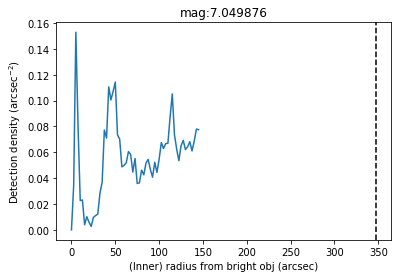

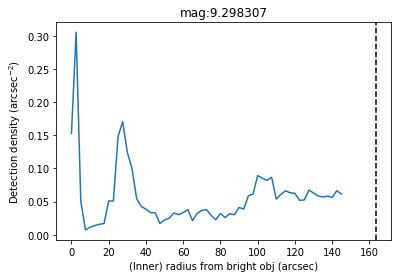

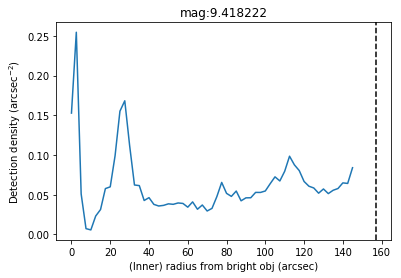

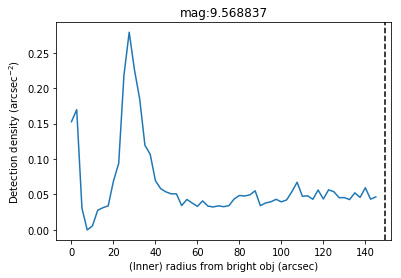

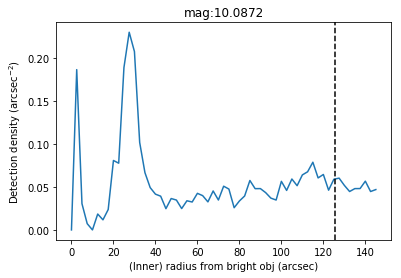

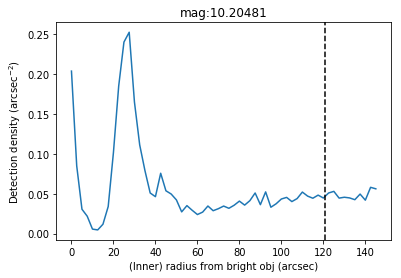

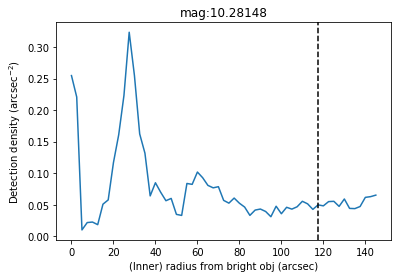

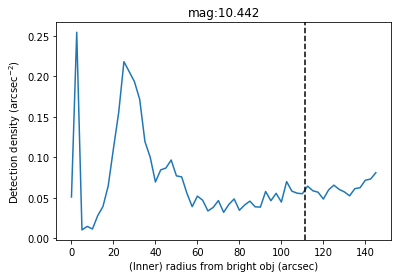

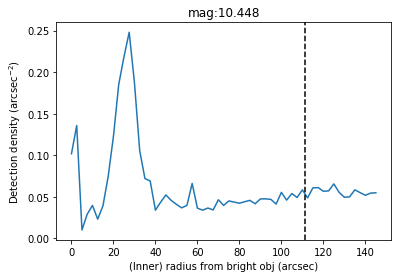

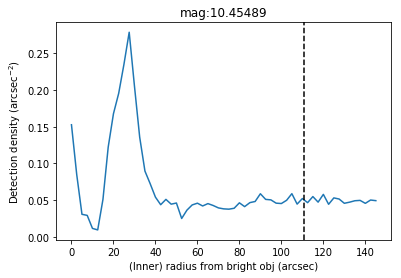

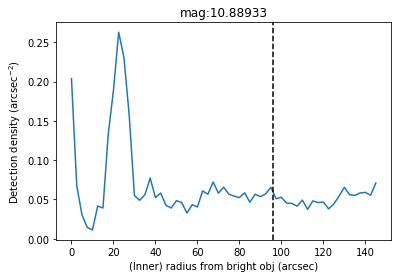

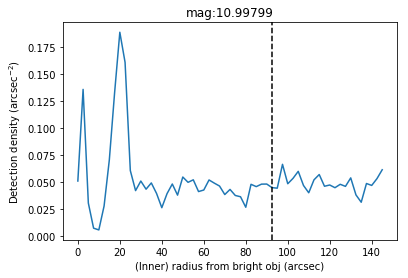

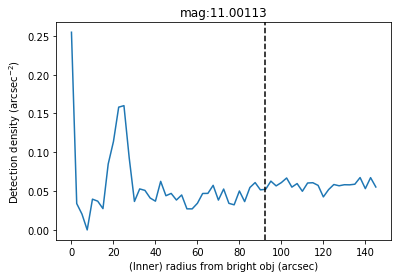

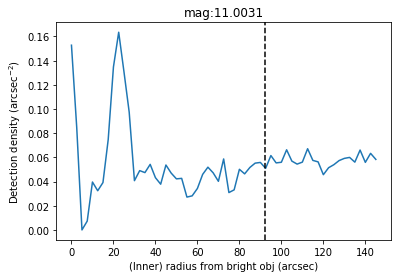

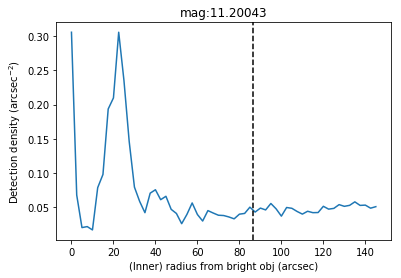

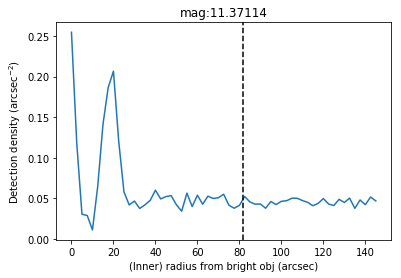

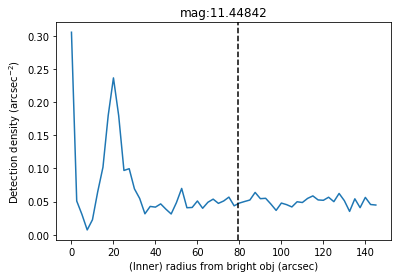

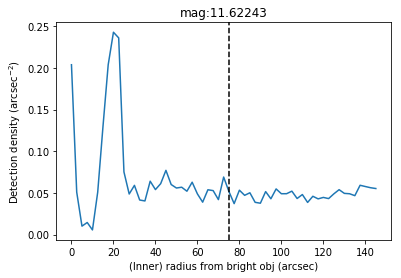

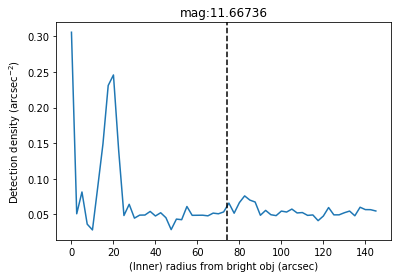

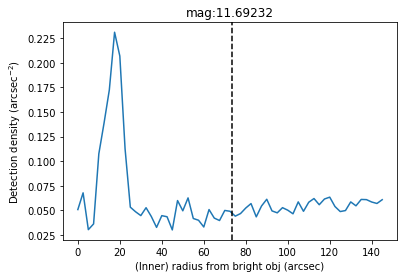

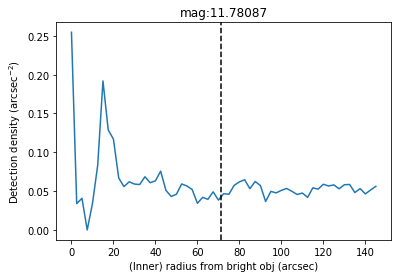

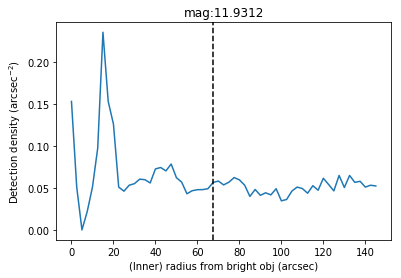

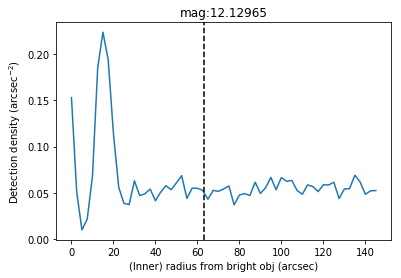

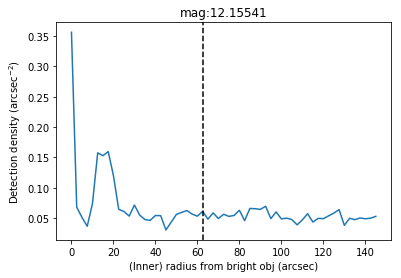

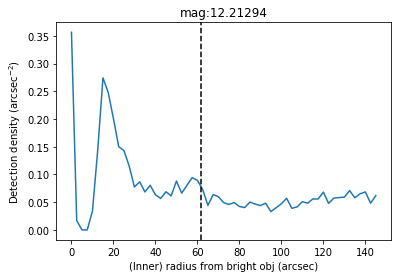

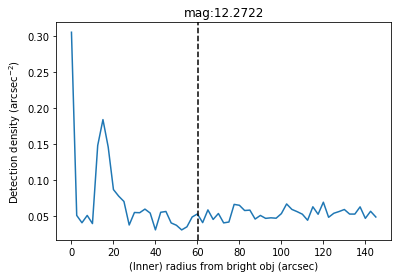

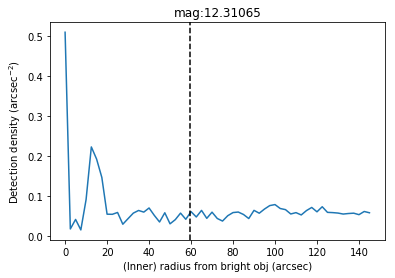

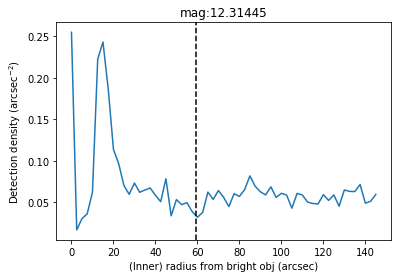

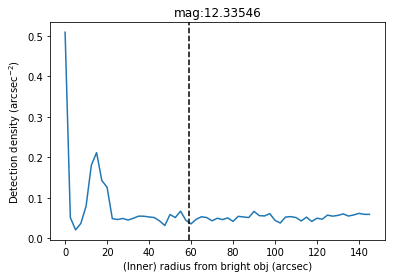

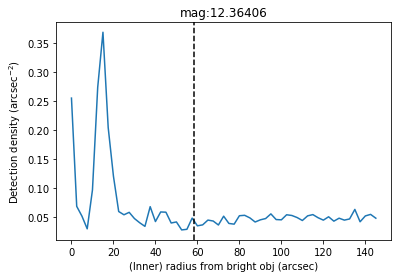

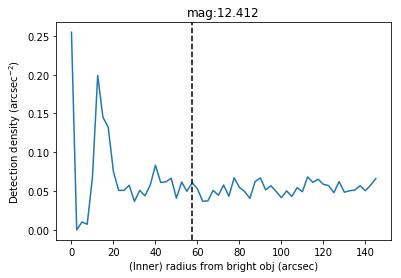

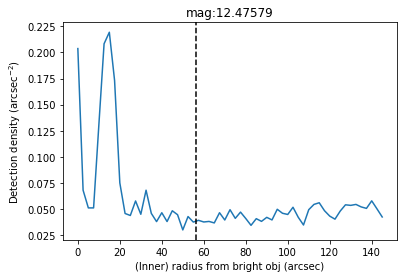

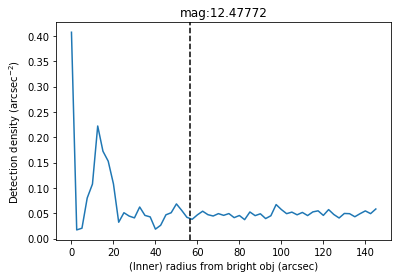

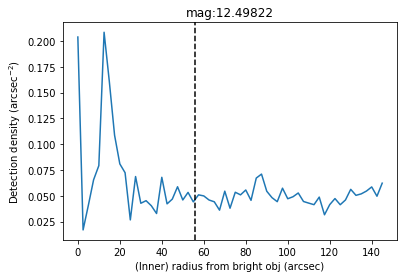

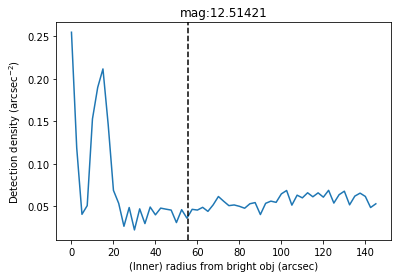

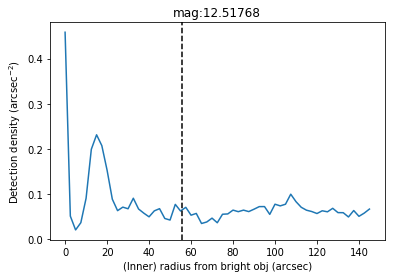

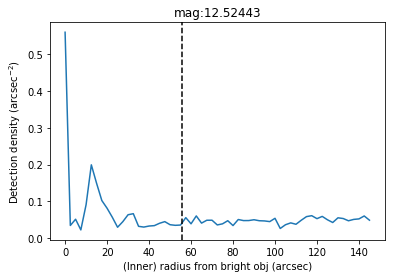

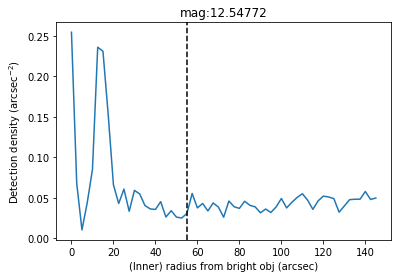

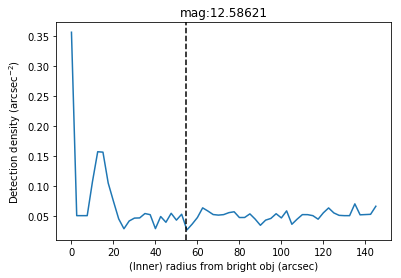

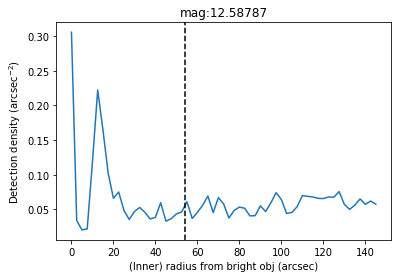

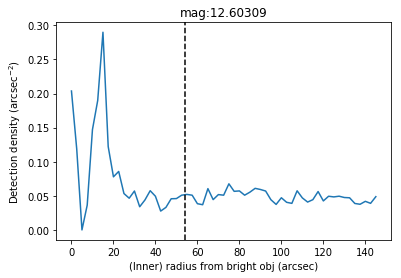

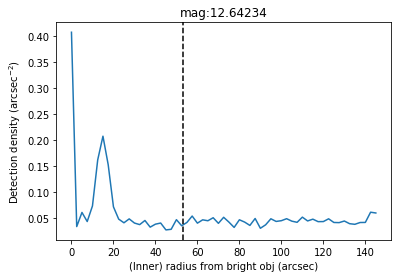

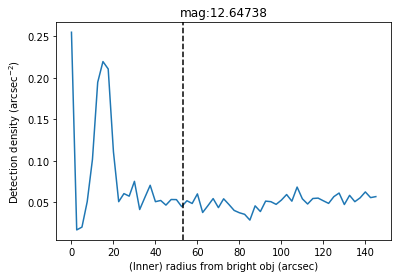

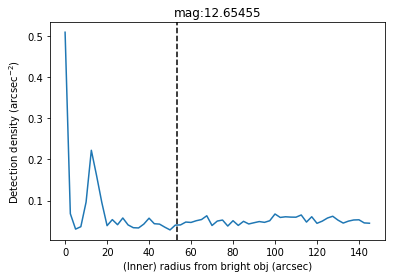

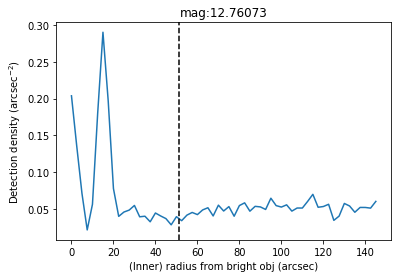

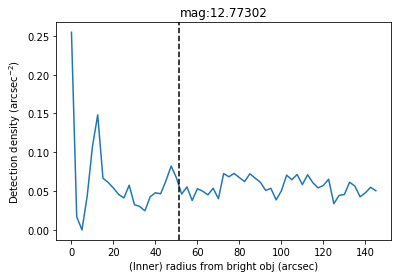

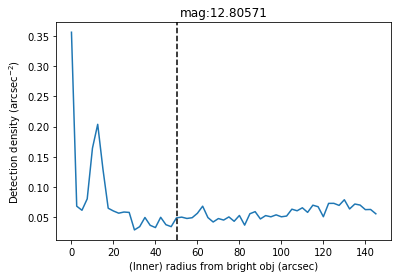

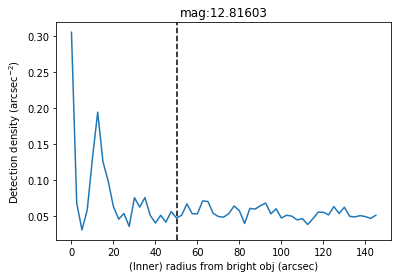

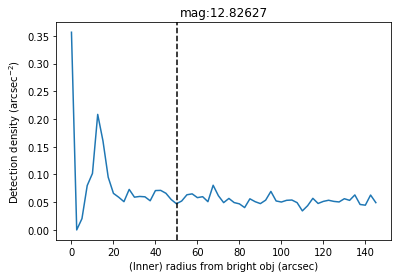

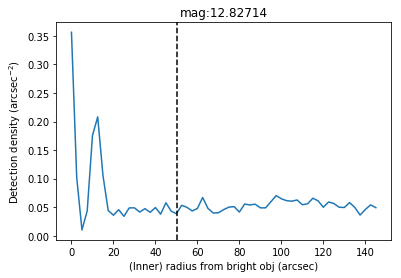

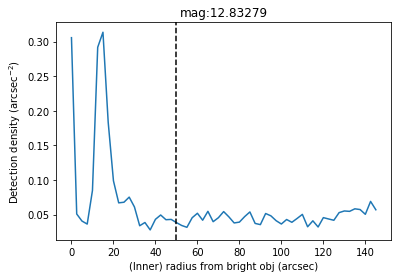

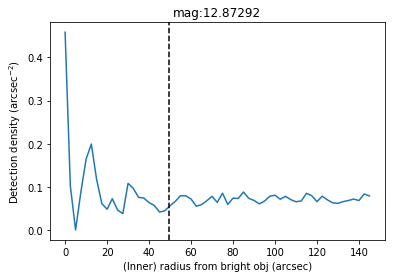

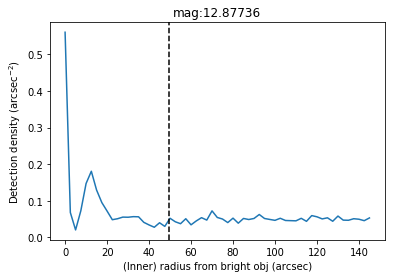

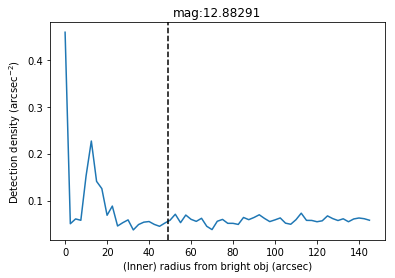

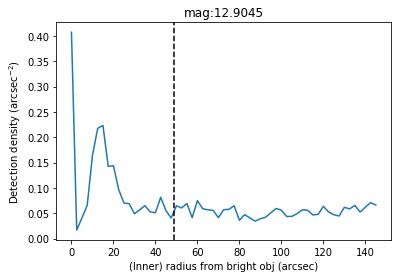

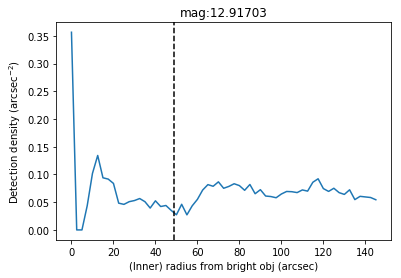

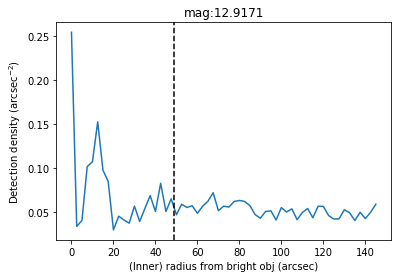

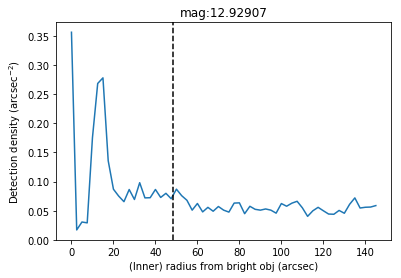

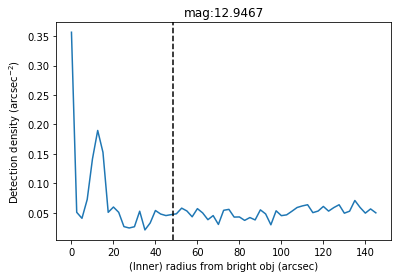

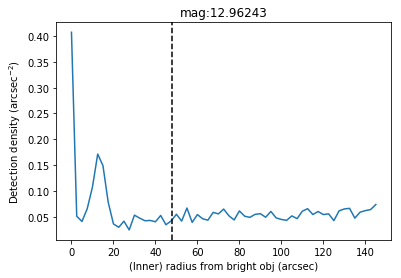

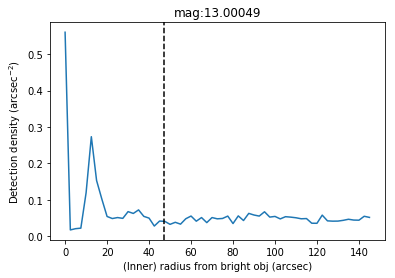

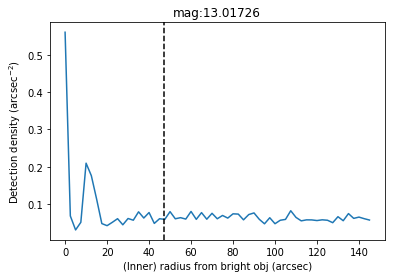

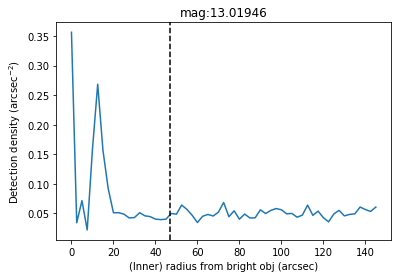

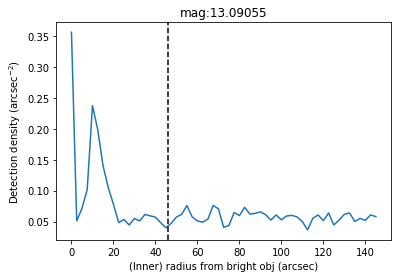

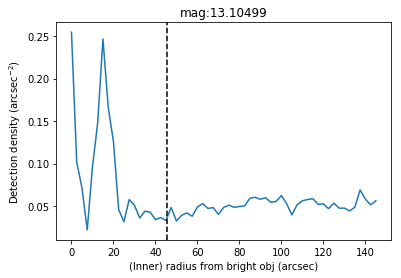

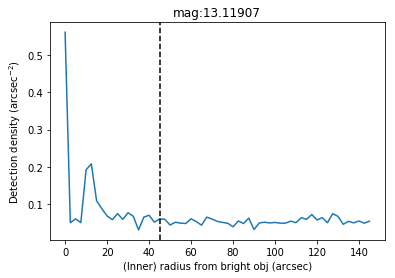

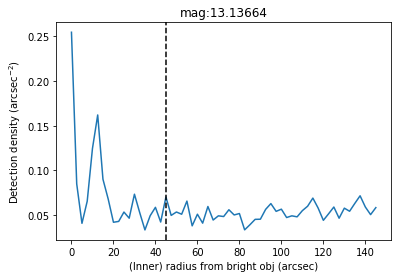

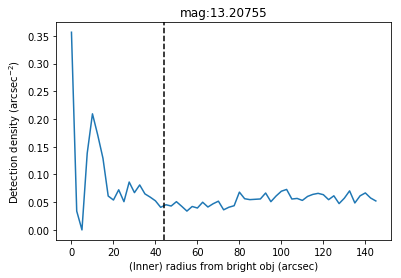

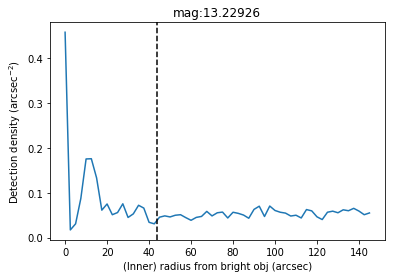

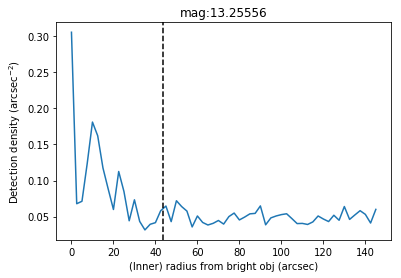

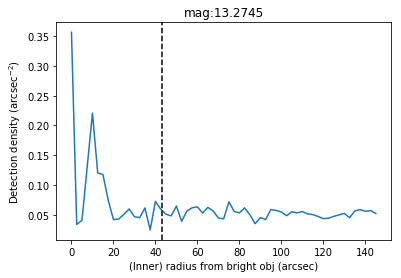

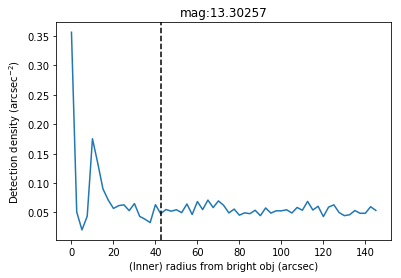

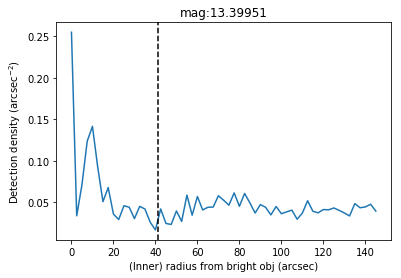

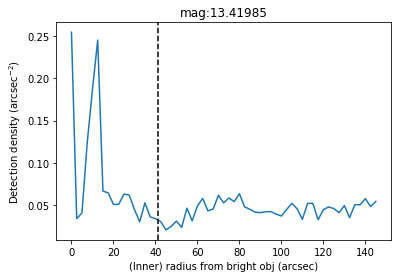

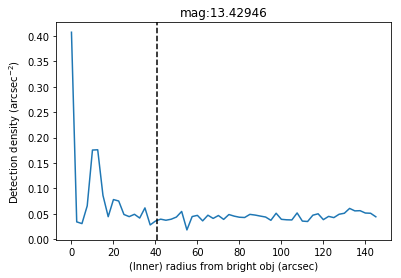

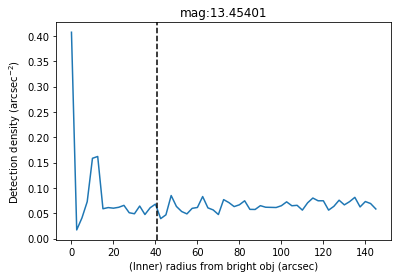

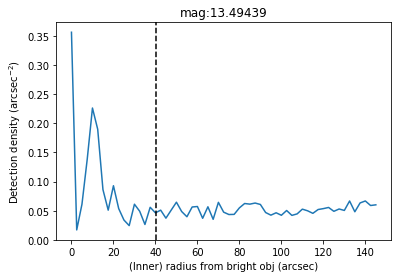

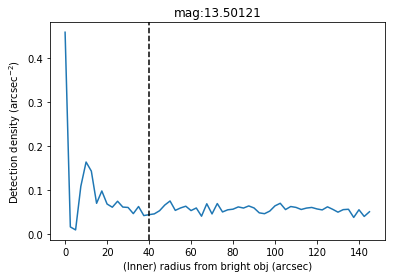

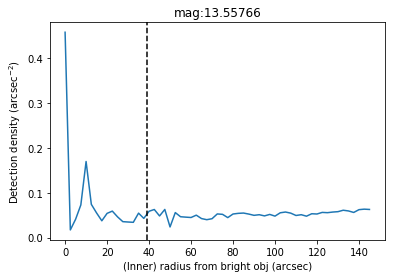

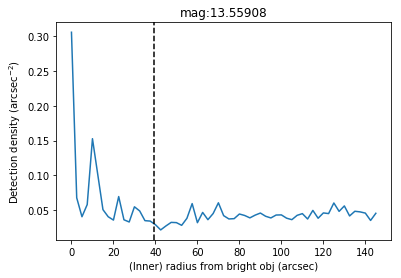

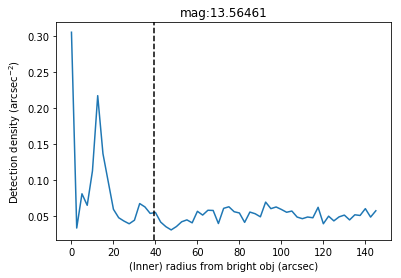

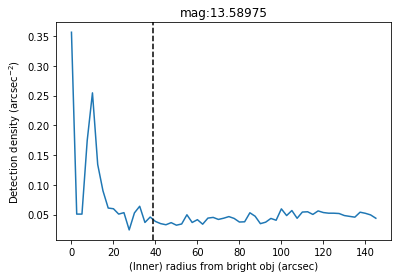

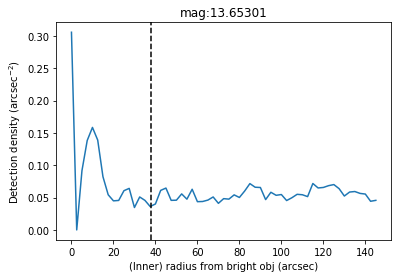

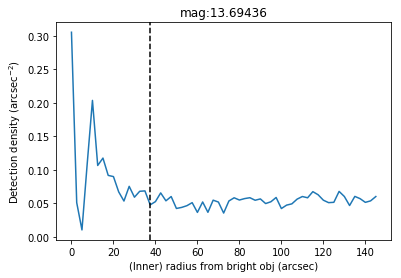

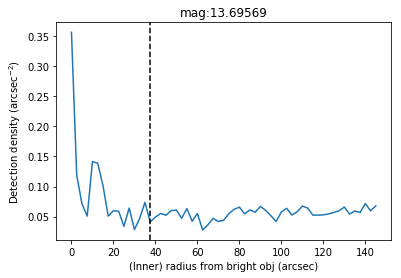

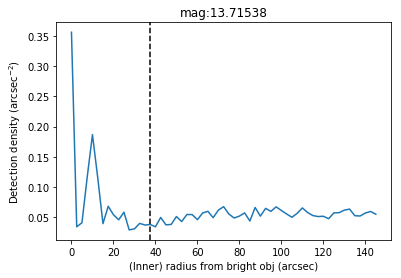

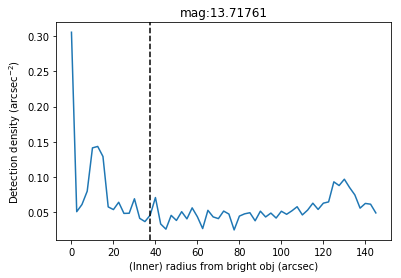

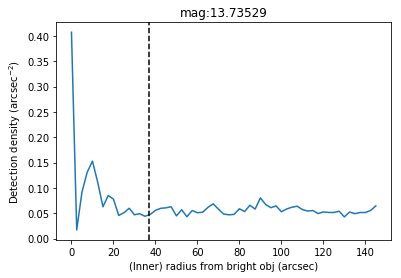

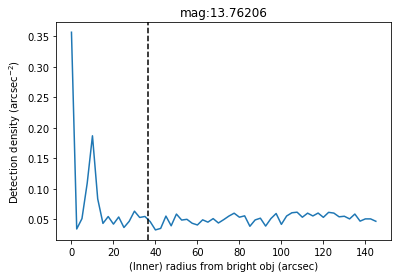

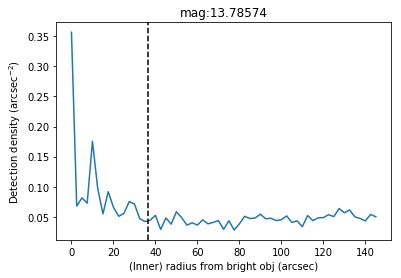

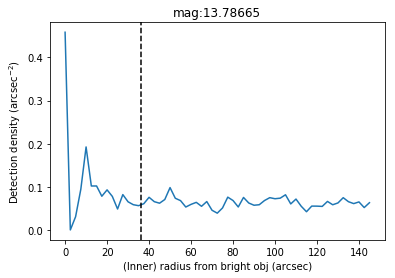

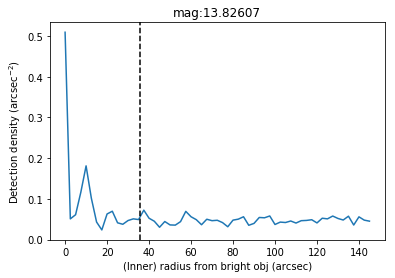

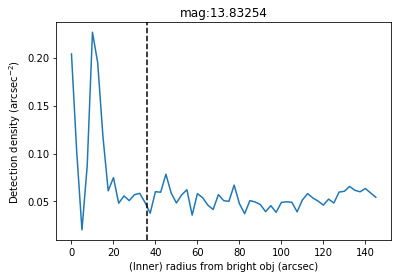

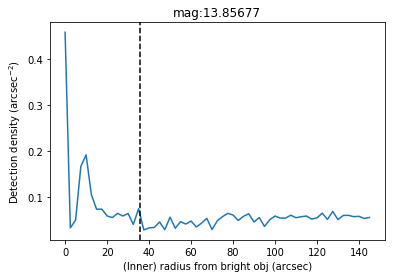

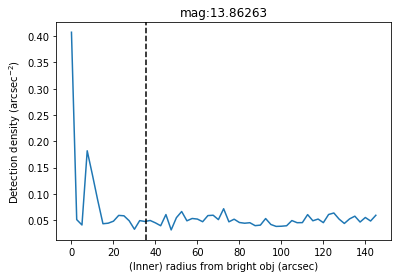

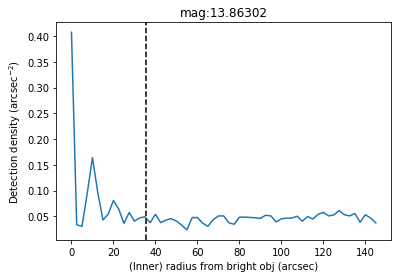

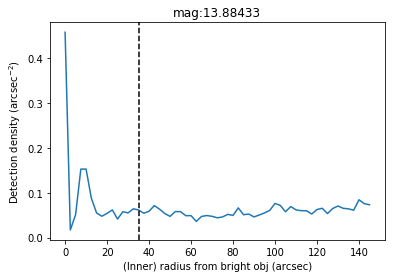

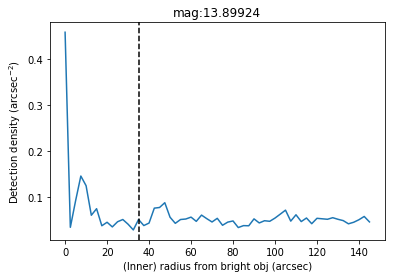

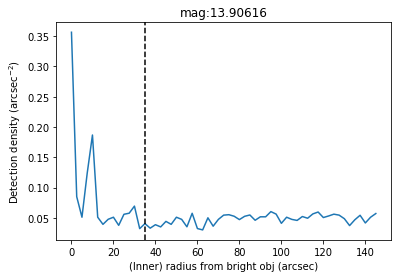

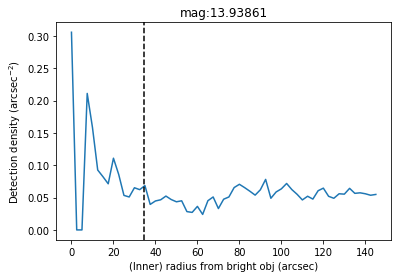

In [12]:
if verbose:
    for dens, mags, rads in zip(densities, brightMags, brightRads):
        for starIdx in np.argsort(mags)[:100]:
            brst = dens[starIdx]
            plt.plot(annRadii[:-1], brst)
            plt.axvline(rads[starIdx], ls='--', c='k')
            plt.xlabel('(Inner) radius from bright obj (arcsec)')
            plt.ylabel(r'Detection density (arcsec$^{-2}$)')
            plt.title('mag:{}'.format(mags[starIdx]))
            plt.show()
            plt.close()

Then average per magnitude bin:

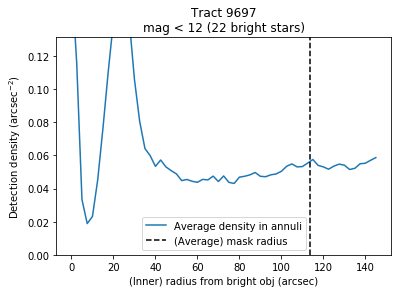

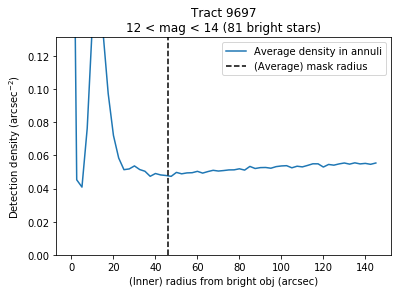

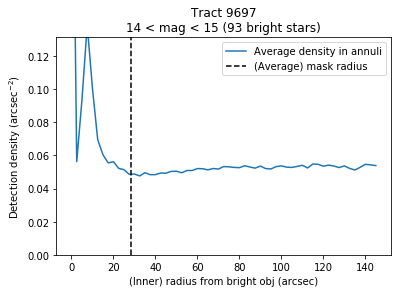

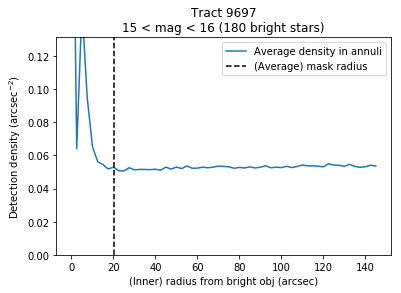

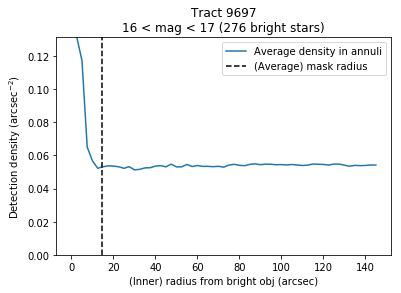

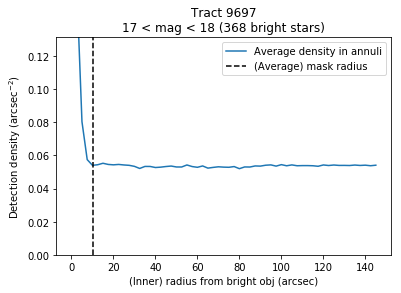

In [13]:
for tract, dens, mags, rads in zip(tractList, densities, brightMags, brightRads):
    for mlab,(mfrom,mto) in zip(mag_labs,zip(mag_bins,mag_bins[1:])):
        binidx = (mags >= mfrom) * (mags < mto)
        # average detection densities around stars in this magnitude bin:
        magDen = np.mean(dens[binidx],axis=0)
        # average Andy mask radii:
        magRad = np.mean(rads[binidx])

        plt.plot(annRadii[:-1], magDen, label='Average density in annuli')
        plt.axvline(magRad, ls='--', c='k', label='(Average) mask radius')

        plt.title("Tract {}\n".format(tract) +
                  mlab + " ({} bright stars)".format(np.sum(binidx)))
        plt.legend()
        
        plt.xlabel('(Inner) radius from bright obj (arcsec)')
        plt.ylabel(r'Detection density (arcsec$^{-2}$)')
        if fixYAxis:
            try:
                plt.ylim(0, 2.5*avgDen)
            except ValueError:
                raise ValueError("Could not set y axis limits; likely because you could not compute\
     average source density")
        
        if savePlots:
            plt.savefig(outputDir + plotStub + '_{}_tract{}_mag{}{}'.format(
                        chosenFilter, tract, mfrom, plotExt))
            
        plt.show()
        plt.close()

Same plot, but more cluttered (for validation/to check whether the chosen plot parameters make sense): add errorbars, both minimal-and-maximal radii masks for chosen magnitude bin, and min and max detection density.

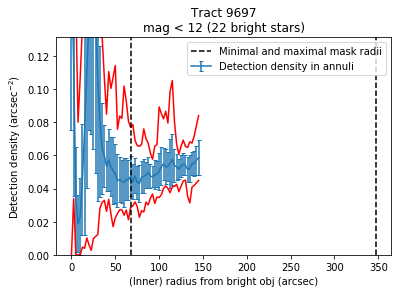

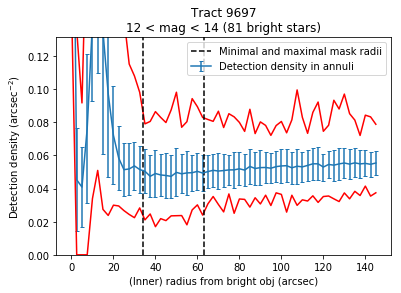

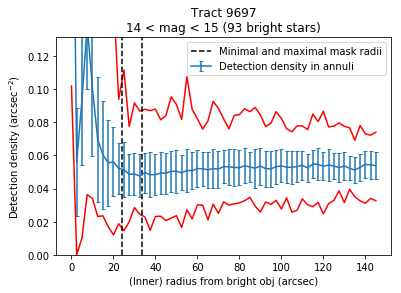

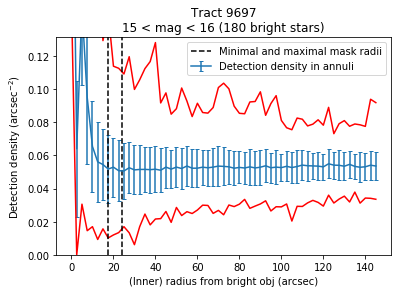

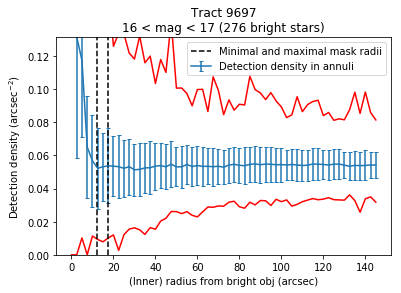

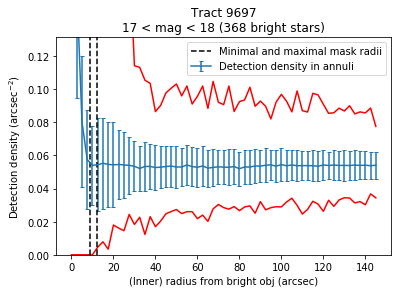

In [14]:
if verbose:
    for tract, dens, mags, rads in zip(tractList, densities, brightMags, brightRads):
        for mlab,(mfrom,mto) in zip(mag_labs,zip(mag_bins,mag_bins[1:])):
            binidx = (mags >= mfrom) * (mags < mto)
            # average detection densities around stars in this magnitude bin:
            magDen = np.mean(dens[binidx],axis=0)
            magDenStd = np.std(dens[binidx],axis=0)
            # average Andy mask radii:
            magRad = np.mean(rads[binidx])
            # and span
            magRadMin = np.min(rads[binidx])
            magRadMax = np.max(rads[binidx])

            plt.errorbar(annRadii[:-1], magDen, yerr=magDenStd, capsize=2,
                         label='Detection density in annuli')
            plt.plot(annRadii[:-1], np.min(dens[binidx],axis=0), c='red')
            plt.plot(annRadii[:-1], np.max(dens[binidx],axis=0), c='red')
            plt.axvline(magRadMin, ls='--', c='k')
            #plt.axvline(magRad, ls='--', c='k')
            plt.axvline(magRadMax, ls='--', c='k', label='Minimal and maximal mask radii')

            plt.title("Tract {}\n".format(tract) +
                      mlab + " ({} bright stars)".format(np.sum(binidx)))

            plt.xlabel('(Inner) radius from bright obj (arcsec)')
            plt.ylabel(r'Detection density (arcsec$^{-2}$)')
            plt.legend()
            if fixYAxis:
                try:
                    plt.ylim(0, 2.5*avgDen)
                except ValueError:
                    raise ValueError("Could not set y axis limits; likely because you could not compute\
         average source density")
 
            if savePlots:
                plt.savefig(outputDir + plotStub + '_{}_tract{}_mag{}_DISTRIB{}'.format(
                            chosenFilter, tract, mfrom, plotExt))
            plt.show()
            plt.close()